In [54]:
import os, joblib
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [55]:
!ls /kaggle/input/d/alimuhammadasad/pashto-poetry-dataset/data

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


abbasinYousuf	karanKhan	    mumtazOrakazi   salimRiaz
ajmalKhattak	khaliqZiari	    munirJan	    shabbirKhanDurrani
allamaAbdulHai	khatirAfridi	    naeemAhmed	    shakirOrakzai
azizMazerwal	khayyamYousufzai    rabiaMumtaz     shoaibKhanKhattak
ghaniKhan	khushalKhanKhattak  rahmanBaba
hamzaBaba	matiullahTurab	    rehmatShah
javedAhmedzai	mohammadAjanyar     sahibShahSabir


In [56]:
# DATA_DIR = "/data/"
DATA_DIR = "/kaggle/input/d/alimuhammadasad/pashto-poetry-dataset/data"

# list of poet names
# Removed the 5 lowest poets
poets = ["abbasinYousuf", "ajmalKhattak", "allamaAbdulHai", "ghaniKhan", "hamzaBaba", "javedAhmedzai", "karanKhan", "khatirAfridi", "khushalKhanKhattak", "matiullahTurab", "mumtazOrakazi", "munirJan", "naeemAhmed", "rabiaMumtaz", "rahmanBaba", "rehmatShah", "sahibShahSabir", "shabbirKhanDurrani", "shakirOrakzai", "shoaibKhanKhattak"]

poet_labels = {poet: i for i, poet in enumerate(poets)}
print(poet_labels)

{'abbasinYousuf': 0, 'ajmalKhattak': 1, 'allamaAbdulHai': 2, 'ghaniKhan': 3, 'hamzaBaba': 4, 'javedAhmedzai': 5, 'karanKhan': 6, 'khatirAfridi': 7, 'khushalKhanKhattak': 8, 'matiullahTurab': 9, 'mumtazOrakazi': 10, 'munirJan': 11, 'naeemAhmed': 12, 'rabiaMumtaz': 13, 'rahmanBaba': 14, 'rehmatShah': 15, 'sahibShahSabir': 16, 'shabbirKhanDurrani': 17, 'shakirOrakzai': 18, 'shoaibKhanKhattak': 19}


In [57]:
# Load and Label the Data
def load_and_label(data_dir, poets, poet_labels):
    data = []
    labels = []

    for poet in poets:
        poet_dir = os.path.join(data_dir, poet)
        file_path = os.path.join(poet_dir, f'{poet}.txt')

        # Check if the file exists
        if not os.path.exists(file_path):
            print(f'{file_path} does not exist')
            continue

        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            data.extend(lines)
            labels.extend([poet_labels[poet]] * len(lines))

    df = pd.DataFrame({'text': data, 'label': labels})
    return data, labels, df

In [58]:
data, labels, df = load_and_label(DATA_DIR, poets, poet_labels)
df.describe()

,label
count,54620.000000
mean,8.625265
std,5.352617
min,0.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,19.000000


In [59]:
X = df['text'].values
y = df['label'].values

# Label Encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)

In [60]:
class PoemClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoemClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten along the sequence length dimension
        x = F.relu(x)
        x = self.fc(x)
        return x

In [61]:
def weighted_train_val_test_split(df, val_size=0.1, test_size=0.2, random_state=42):
    train_dfs = []
    val_dfs = []
    test_dfs = []

    for poet_label in df['label'].unique():
        poet_df = df[df['label'] == poet_label]
        
        # Split poet data into train and temp sets
        train_poet, temp_poet = train_test_split(
            poet_df, test_size=(val_size + test_size), random_state=random_state, stratify=poet_df['label']
        )
        
        # Calculate proportion of temp set to go to validation and testing
        val_prop = val_size / (val_size + test_size)
        
        # Split temp set into validation and test sets
        val_poet, test_poet = train_test_split(
            temp_poet, test_size=(1 - val_prop), random_state=random_state, stratify=temp_poet['label']
        )

        # Append each split to their respective lists
        train_dfs.append(train_poet)
        val_dfs.append(val_poet)
        test_dfs.append(test_poet)

    # Concatenate all individual splits to get the final train, validation, and test dataframes
    train_df = pd.concat(train_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    val_df = pd.concat(val_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = pd.concat(test_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return train_df, val_df, test_df


In [62]:
# Apply the weighted split
train_df, val_df, test_df = weighted_train_val_test_split(df, val_size=0.1, test_size=0.2)

# Extracting features and labels for each set
poems_train, labels_train = train_df['text'].values, train_df['label'].values
poems_val, labels_val = val_df['text'].values, val_df['label'].values
poems_test, labels_test = test_df['text'].values, test_df['label'].values

# Transform texts into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

poems_train_tfidf = tfidf_vectorizer.fit_transform(poems_train).toarray()
poems_val_tfidf = tfidf_vectorizer.transform(poems_val).toarray()
poems_test_tfidf = tfidf_vectorizer.transform(poems_test).toarray()

In [63]:
# Reshape for LSTM input
poems_train_tfidf = poems_train_tfidf.reshape(poems_train_tfidf.shape[0], 1, poems_train_tfidf.shape[1])
poems_val_tfidf = poems_val_tfidf.reshape(poems_val_tfidf.shape[0], 1, poems_val_tfidf.shape[1])
poems_test_tfidf = poems_test_tfidf.reshape(poems_test_tfidf.shape[0], 1, poems_test_tfidf.shape[1])

### ------------------------------------------- ###

In [50]:
poems_train, poems_temp, labels_train, labels_temp = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

poems_train_tfidf = tfidf_vectorizer.fit_transform(poems_train).toarray()
poems_val_tfidf = tfidf_vectorizer.transform(poems_val).toarray()
poems_test_tfidf = tfidf_vectorizer.transform(poems_test).toarray()

In [51]:
poems_train_tfidf = poems_train_tfidf.reshape(poems_train_tfidf.shape[0], 1, poems_train_tfidf.shape[1])
poems_val_tfidf = poems_val_tfidf.reshape(poems_val_tfidf.shape[0], 1, poems_val_tfidf.shape[1])
poems_test_tfidf = poems_test_tfidf.reshape(poems_test_tfidf.shape[0], 1, poems_test_tfidf.shape[1])

#### --------------------------------------------------

In [64]:
# Plot training history
def plot_training_history(history, title="Model Training"):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [65]:
# # Define the LSTM Model
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(len(set(encoded_labels)), activation='softmax'))

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define the early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model
# history = model.fit(X_train_tfidf, y_train, validation_data=(X_vals_tfidf, y_vals), epochs=10, batch_size=32, callbacks=[early_stopping])

# ----------------------------------------- 
model = Sequential()
model.add(Bidirectional(LSTM(64)))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(poems_train_tfidf, labels_train, validation_data=(poems_val_tfidf, labels_val), epochs=20, batch_size=16, callbacks=[early_stopping])
# history = model.fit(poems_train_tfidf, labels_train, validation_data=(poems_val_tfidf, labels_val), epochs=20, batch_size=32)

# ------------------------------------------

Epoch 1/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.1521 - loss: 2.9164 - val_accuracy: 0.1562 - val_loss: 2.6631
Epoch 2/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.1816 - loss: 2.5826 - val_accuracy: 0.3232 - val_loss: 2.3498
Epoch 3/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3706 - loss: 2.2408 - val_accuracy: 0.4268 - val_loss: 2.0587
Epoch 4/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4637 - loss: 1.9425 - val_accuracy: 0.4804 - val_loss: 1.8524
Epoch 5/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5303 - loss: 1.7267 - val_accuracy: 0.5244 - val_loss: 1.6959
Epoch 6/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5782 - loss: 1.5422 - val_accuracy: 0.5526 - val_loss: 1.5763
Epoch 7/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6167 - loss: 1.4004 - val_accuracy: 0.5710 - val_loss: 1.4862
Epoch 8/20
2389/2389 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6447 - loss: 1

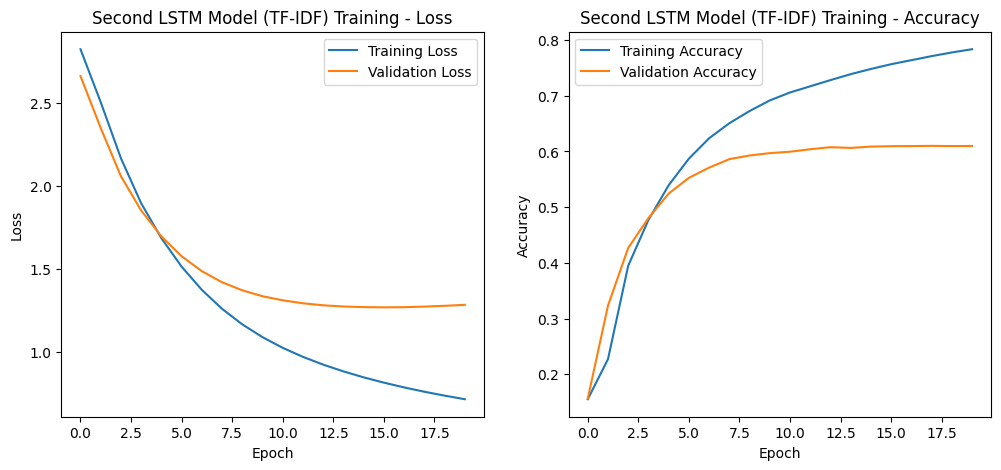

342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5997 - loss: 1.3020
Test Accuracy: 0.5963
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


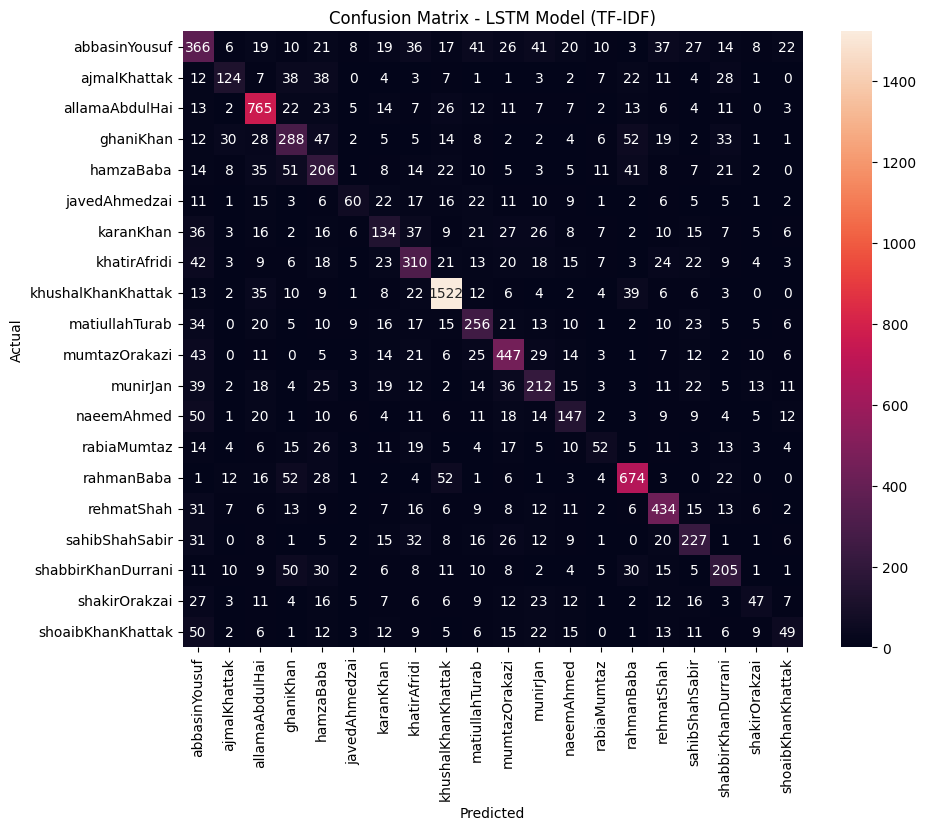

In [66]:
# plot_training_history(history, title="Second LSTM Model (TF-IDF) Training")

# # Evaluate on the test set
# test_loss, test_accuracy = model.evaluate(X_test_tfidf, y_test)
# print(f"Test Accuracy: {test_accuracy:.4f}")

# # Make predictions on the test set
# y_probs = model.predict(X_test_tfidf)
# y_preds = np.argmax(y_probs, axis=1)

# # Confusion Matrix
# confusion_matrix = confusion_matrix(y_test, y_preds)
# plt.figure(figsize=(10, 8))
# sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix - LSTM Model (TF-IDF)')

# # Classification Report
# classification_rep = classification_report(y_test, y_preds, target_names=poets)
# print(classification_rep)
# plt.show()

plot_training_history(history, title="Second LSTM Model (TF-IDF) Training")

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(poems_test_tfidf, labels_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test set
y_probs = model.predict(poems_test_tfidf)
y_preds = np.argmax(y_probs, axis=1)

# Confusion Matrix
confusion_matrix = confusion_matrix(labels_test, y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=poets, yticklabels=poets)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Model (TF-IDF)')
plt.show()
